In [1]:
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
import pandas as pd
import geopandas as gpd
import ee
import geemap
import geemap.colormaps as cm

from shapely.geometry import Polygon

import sys
sys.path.insert(1, '../src')
import data_sources as dts

service_account = 'pred-exp-deault@predictor-de-expansion.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'privatekey.json')
#ee.Initialize(credentials)
ee.Initialize()

In [2]:
data_path = '../data/'
cities_uc = gpd.read_file(data_path + 'output/cities/cities_uc.gpkg')
cities_fua = gpd.read_file(data_path + 'output/cities/cities_fua.gpkg')

country = widgets.Combobox(
    placeholder='país',
    value='Mexico',
    options=list(cities_uc.country.unique()),
    description='País',
    ensure_option=True,
    disabled=False
)

city = widgets.Combobox(
    value='Mérida',
    placeholder='ciudad',
    options=list(cities_uc[cities_uc.country == 'Mexico'].city),
    description='Ciudad',
    ensure_option=True,
    disabled=False
)

def on_country_change(change):
    country = change.new
    city.options = list(cities_uc[cities_uc.country == country].city)
    
country.observe(on_country_change, 'value')

submit = widgets.Button(
    description='Submit',
    button_style='primary',
    tooltip='Click the submit the request to center on city',
)


def submit_clicked(b):
    uc = cities_uc.loc[(cities_uc.country == country.value) &
                   (cities_uc.city == city.value)]
    fua = cities_fua.loc[(cities_fua.country == country.value) &
                   (cities_fua.city == city.value)]

    year = year_selector.value
    
    # Clears all but basemap
    for layer in Map.layers[2:]:
        Map.remove_ee_layer(layer.name)
    if hasattr(Map, 'legends'):
        Map.remove_legends()
    if hasattr(Map, 'colorbars'):
        Map.remove_colorbars()
        
    
    # Center on city
    poly_uc = uc.geometry.values[0]
    poly_fua = fua.geometry.values[0]
    point = poly_fua.centroid
    Map.set_center(point.x, point.y, zoom=10)
    
    # Add urban center and fua polygons
    poly_uc_ee = geemap.geopandas_to_ee(uc)
    poly_fua_ee = geemap.geopandas_to_ee(fua)
    Map.addLayer(poly_uc_ee.style(color='000000', fillColor='00000000'), {}, 'Urban center')
    Map.addLayer(poly_fua_ee.style(color='0000ff', fillColor='00000000'), {}, 'Functional Urban Area')
    
    # Add expanded bounding box
    bbox = dts.get_roi(fua, buff=7, buff_type='km')
    bbox_ee = geemap.geopandas_to_ee(bbox)
    Map.addLayer(bbox_ee.style(color='ff0000', fillColor='00000000'), {}, 'Region of interest')
    
    # Add data sources
    for src, box in urban_boxes.items():
        if box.value:
            dts.map_src(Map, src, year, bbox_ee, clip=True)

    for src, box in lc_boxes.items():
        if box.value:
            dts.map_src(Map, src, year, bbox_ee, clip=True)
            
    for src, box in pop_boxes.items():
        if box.value:
            dts.map_src(Map, src, year, bbox_ee, clip=True)

    # Add Landsat composite
    dts.map_landsat(Map, roi=bbox, year=year, clip=True, col=1)
    

submit.on_click(submit_clicked)

hbox1 = widgets.HBox([country, city, submit])
hbox1

In [3]:
urban_boxes = {}
lc_boxes = {}
pop_boxes = {}
for s in dts.sources.keys():
    if dts.sources[s]['class'] == 'urban':
        urban_boxes[s] = widgets.Checkbox(
            value=False,
            description=s  
        )
    if dts.sources[s]['class'] == 'landcover':
        lc_boxes[s] = widgets.Checkbox(
        value=False,
        description=s  
        )
    if dts.sources[s]['class'] == 'population':
        pop_boxes[s] = widgets.Checkbox(
            value=False,
            description=s  
        )
    
vbox_urban = widgets.VBox([widgets.HTML('Urban')] + list(urban_boxes.values()),
                          layout=widgets.Layout(border='solid 2px'))

vbox_lc = widgets.VBox([widgets.HTML('Land Cover')] + list(lc_boxes.values()),
                      layout=widgets.Layout(border='solid 2px'))

vbox_pop = widgets.VBox([widgets.HTML('Population')] + list(pop_boxes.values()),
                      layout=widgets.Layout(border='solid 2px'))

sources_hbox = widgets.HBox([vbox_urban, vbox_lc, vbox_pop])
year_selector = widgets.BoundedIntText(
        value=2015,
        min=1985,
        max=2020,
        step=1,
        description='Year:',
        disabled=False
    )

sources_vbox = widgets.VBox([year_selector, sources_hbox])
sources_vbox

In [4]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

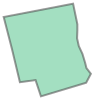

In [18]:
from shapely.geometry import Polygon, MultiPolygon, shape, Point
import geopandas as gp
def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
    return new_geo

In [35]:
import fiona

in_kml = data_path + 'input/distrito.kml'
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
distrito = gpd.read_file(in_kml, driver='KML')#.to_crs(gdf_fine_dist.crs)
distrito.geometry = convert_3D_2D(distrito.geometry)
fc = geemap.geopandas_to_ee(distrito)

#distrito = geemap.kml_to_ee(in_kml)
Map.addLayer(fc.style(color='ff0000', fillColor='ff0000'), {}, "Distrito")

In [5]:
fua = cities_fua.loc[(cities_fua.country == 'Mexico') &
                   (cities_fua.city == 'Zamora')]
bbox = dts.get_roi(fua, buff=10, buff_type='km').geometry[0]
bbox_ee = ee.Geometry.Polygon([t for t in zip(*bbox.exterior.coords.xy)])

In [26]:
lsib = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
country = lsib.filterMetadata('country_na','equals','Colombia')

In [27]:
slope = ee.ImageCollection('projects/sat-io/open-datasets/Geomorpho90m/slope')

In [42]:
img = slope.first()

In [45]:
geemap.image_stats(img).getInfo()

{'max': {'b1': 61.92815399169922},
 'mean': {'b1': 2.833981352918849},
 'min': {'b1': 0},
 'std': {'b1': 4.661623915806865},
 'sum': {'b1': 18320504.842414837}}

In [52]:
def get_col_max(col):

    def get_crs_iter(img, first):
        return ee.List(first).add(geemap.image_stats(img))

    crs_l = col.iterate(get_crs_iter, ee.List([])).getInfo()

    #assert len(np.unique(crs_l)) == 1

    return crs_l

In [76]:
lsib = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
country = lsib.filterMetadata('country_na','equals','Russia')
slope2 = slope.filterBounds(country)
ll = get_col_max(slope2)
max([l['max']['b1'] for l in ll])

76.78672790527344